## 라이브러리 및 경로 설정

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 이미지 경로 정의 및 이미지 로드

In [2]:
person_img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/person.jpg'
person_img_orig = cv2.imread(person_img_path) 
print(person_img_orig.shape)

animal_img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/animal.jpg'
animal_img_orig = cv2.imread(animal_img_path) 
print(animal_img_orig.shape)

sea_img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/sea.jpg'
sea_img_orig = cv2.imread(sea_img_path) 
print(sea_img_orig.shape)

(3648, 5472, 3)
(5184, 3456, 3)
(3000, 4000, 3)


## DeepLab 모델 클래스 정의

In [3]:
class DeepLabModel(object):
    # 모델 관련 설정
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        # 모델의 그래프와 가중치 불러오기
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        # 이미지 전처리 (크기 조정 및 RGB 변환)
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    def run(self, image):
        # 입력 이미지에 대한 DeepLab 모델 추론 실행
        img_input = self.preprocess(image)

        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map


## DeepLab 모델 다운로드 및 로드

In [4]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz', download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


## 레이블 이름 정의

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]


## 사람 이미지에 대한 DeepLab 모델 실행 및 시각화

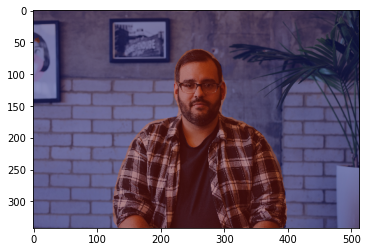

In [6]:
img_resized, seg_map = MODEL.run(person_img_orig)

# 이미지 마스킹
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_resized, 0.6, color_mask, 0.35, 0.0)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


## 사람 이미지와 크기를 맞춘 마스크 이미지 시각화

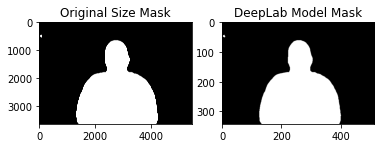

In [7]:
img_mask_up = cv2.resize(img_mask, person_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()


## 사람 이미지의 배경만 추출하여 시각화

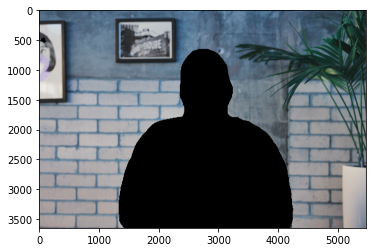

In [8]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(person_img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()


## 배경을 블러 처리하여 시각화

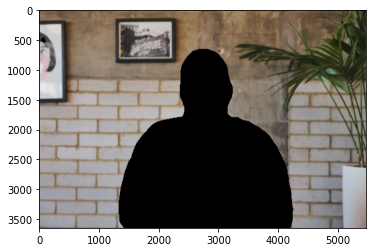

In [9]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


## 사람 이미지와 마스크를 합성하여 시각화

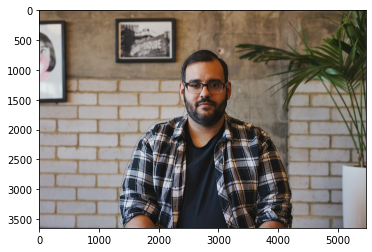

In [10]:
img_concat = np.where(img_mask_color == 255, person_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


## 사람과 동물 이미지를 해당 배경과 합성하여 시각화

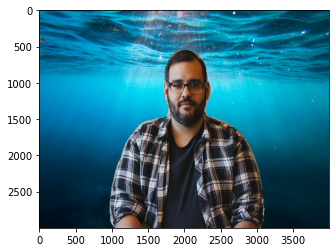

In [11]:
img_resized = cv2.resize(
    person_img_orig, (sea_img_orig.shape[1], sea_img_orig.shape[0]))
img_mask_resized = cv2.resize(
    img_mask_color, (sea_img_orig.shape[1], sea_img_orig.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_resized, sea_img_orig)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 동물 이미지에 대한 DeepLab 모델 실행 및 시각화

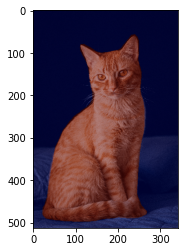

In [12]:
animal_img_resized, animal_seg_map = MODEL.run(animal_img_orig)

# 이미지 마스킹
animal_seg_map = np.where(animal_seg_map == 8, 8, 0)
animal_img_mask = animal_seg_map * (255/animal_seg_map.max())
animal_img_mask = animal_img_mask.astype(np.uint8)
animal_color_mask = cv2.applyColorMap(animal_img_mask, cv2.COLORMAP_JET)
animal_img_show = cv2.addWeighted(animal_img_resized, 0.6, animal_color_mask, 0.35, 0.0)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(animal_img_show, cv2.COLOR_BGR2RGB))
plt.show()


## 동물 이미지와 크기를 맞춘 마스크 이미지 시각화

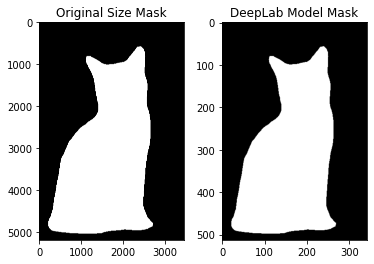

In [13]:
animal_img_mask_up = cv2.resize(animal_img_mask, animal_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, animal_img_mask_up = cv2.threshold(animal_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(animal_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(animal_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()


## 동물 이미지의 배경만 추출하여 시각화

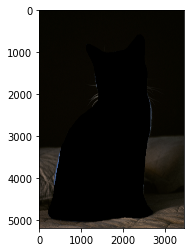

In [14]:
animal_img_mask_color = cv2.cvtColor(animal_img_mask_up, cv2.COLOR_GRAY2BGR)
animal_img_bg_mask = cv2.bitwise_not(animal_img_mask_color)
animal_img_bg = cv2.bitwise_and(animal_img_orig, animal_img_bg_mask)
plt.imshow(animal_img_bg)
plt.show()


## 배경을 블러 처리하여 시각화

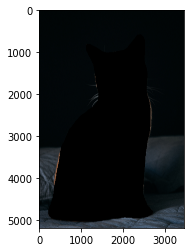

In [15]:
animal_img_bg_blur = cv2.blur(animal_img_bg, (13,13))
plt.imshow(cv2.cvtColor(animal_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 동물 이미지와 마스크를 합성하여 시각화

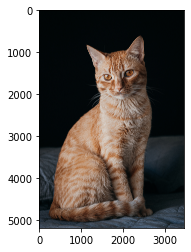

In [16]:
animal_img_concat = np.where(animal_img_mask_color == 255, animal_img_orig, animal_img_bg_blur)
plt.imshow(cv2.cvtColor(animal_img_concat, cv2.COLOR_BGR2RGB))
plt.show()


## 동물 이미지를 해당 배경과 합성하여 시각화

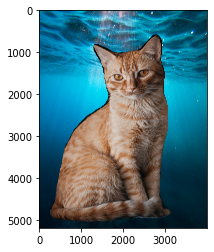

In [17]:
animal_resized = cv2.resize(animal_img_orig, (sea_img_orig.shape[1], animal_img_orig.shape[0]))
sea_img_resized = cv2.resize(sea_img_orig, (sea_img_orig.shape[1], animal_img_orig.shape[0]))
animal_img_mask_resized = cv2.resize(animal_img_mask_color, (sea_img_orig.shape[1], animal_img_orig.shape[0]))

animal_sea_concat = np.where(animal_img_mask_resized == 255, animal_resized, sea_img_resized)

plt.imshow(cv2.cvtColor(animal_sea_concat, cv2.COLOR_BGR2RGB))
plt.show()


## 사람과 동물 이미지를 리사이즈하여 시각화

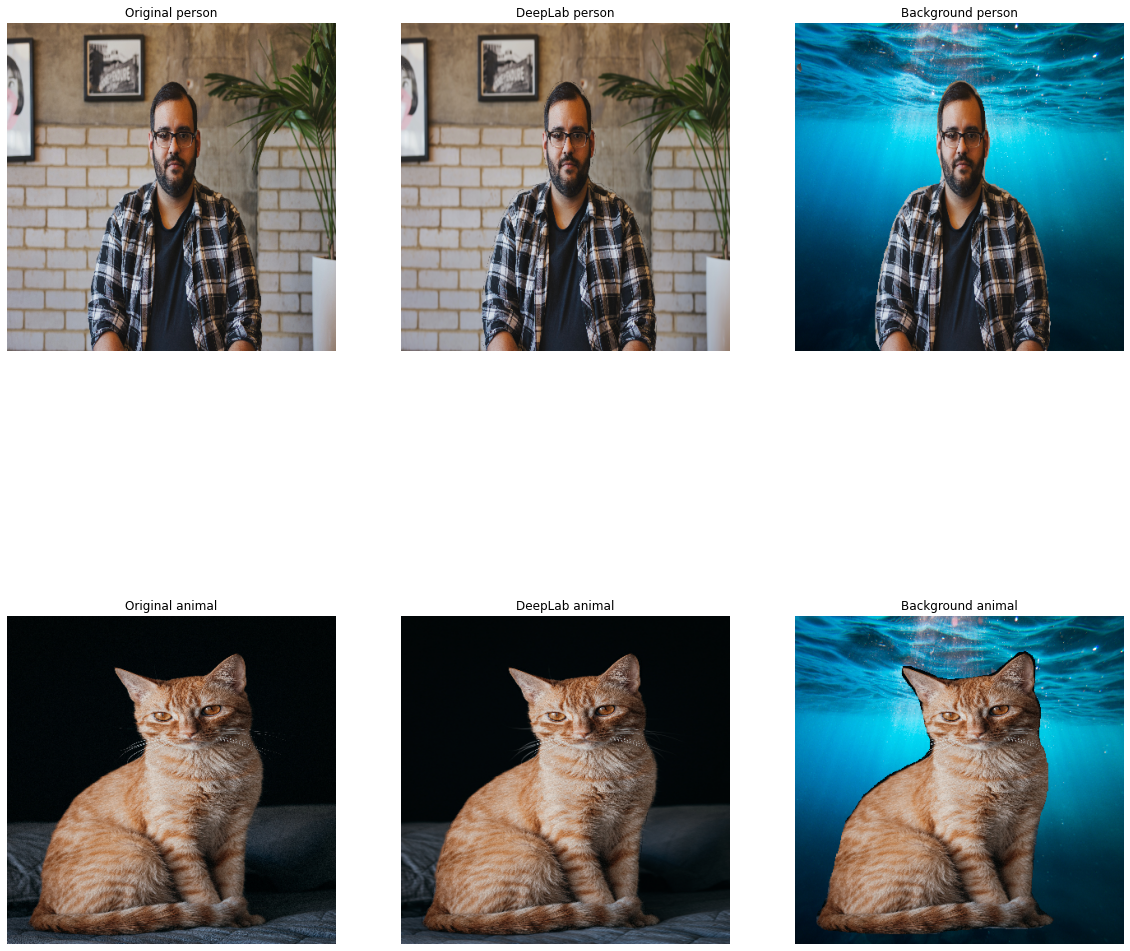

In [18]:
plt.figure(figsize=(20, 20))

ax = plt.subplot(2, 3, 1)
plt.axis('off')
person_img_orig_resized = cv2.resize(person_img_orig, (400, 400))
plt.imshow(cv2.cvtColor(person_img_orig_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original person')

ax = plt.subplot(2, 3, 2)
plt.axis('off')
img_concat_resized = cv2.resize(img_concat, (400, 400))
plt.imshow(cv2.cvtColor(img_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab person')

ax = plt.subplot(2, 3, 3)
plt.axis('off')
img_background_concat_resized = cv2.resize(img_background_concat, (400, 400))
plt.imshow(cv2.cvtColor(img_background_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Background person')

ax = plt.subplot(2, 3, 4)
plt.axis('off')
animal_img_orig_resized = cv2.resize(animal_img_orig, (400, 400))
plt.imshow(cv2.cvtColor(animal_img_orig_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original animal')

ax = plt.subplot(2, 3, 5)
plt.axis('off')
animal_img_concat_resized = cv2.resize(animal_img_concat, (400, 400))
plt.imshow(cv2.cvtColor(animal_img_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab animal')

ax = plt.subplot(2, 3, 6)
plt.axis('off')
animal_sea_concat_resized = cv2.resize(animal_sea_concat, (400, 400))
plt.imshow(cv2.cvtColor(animal_sea_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Background animal')

plt.show()


<br/>
<br/>

# 사진에서의 문제점

1. 세그멘테이션 마스크가 정확하지 않아 사람의 일부분이 배경과 혼합되었습니다.
 <br/>
 
2. 사람과 사물이 세분화되지 않고 같이 블러 처리되었습니다.
 <br/>
 
3. 블러 효과가 뚜렷한 경계 부근에서 세그멘테이션 오류가 발생하였습니다.
 <br/>
 
# 해결방안

위의 문제점을 개선하고 세그멘테이션 마스크를 보완하기 위해 다음과 같은 해결 방법을 제안합니다.
<br/>

1. 정확성 향상
<br/>
DeepLab 모델의 성능을 개선하거나 다른 정확도 높은 모델을 사용하여 세그멘테이션 마스크의 정확성을 높입니다. 높은 정확성을 갖는 세그멘테이션 마스크는 사람과 배경을 더욱 정확하게 분리할 수 있습니다.
<br/>
<br/>
2. 세분화
<br/>
사람과 사물을 보다 세분화된 영역으로 분리하여 블러 처리합니다. 이를 통해 사물과 배경을 더욱 자연스럽게 구분하고 인물모드의 결과가 더욱 자연스러워집니다.
<br/>
<br/>
3. 포스트 프로세싱
<br/>
세그멘테이션 마스크를 기반으로 추가적인 후처리 기술을 적용하여 세그멘테이션 마스크의 오류를 보정합니다. 세그멘테이션 마스크의 경계 부분을 부드럽게 처리하거나 보간 기법을 사용하여 자연스러운 결과를 얻을 수 있습니다.
<br/>
<br/>
4. 다중 모델 조합
<br/>
여러 모델을 조합하여 더 나은 성능을 얻을 수 있습니다. 예를 들어, 사람의 인식에 더 특화된 모델과 배경의 인식에 특화된 모델을 함께 사용하여 각각의 역할에 맞게 세그멘테이션을 수행하고 결과를 합칠 수 있습니다.
<br/>
<br/>
5. 사전 학습된 모델 사용
<br/>
이미지 분야의 사전 학습된 모델을 사용하여 세그멘테이션을 수행하면 성능이 향상될 수 있습니다. 사전 학습된 모델은 대규모 데이터셋으로 사전에 학습된 상태이므로 일반적인 사물과 배경을 더욱 정확하게 구분할 수 있습니다.